This notebook compares the performance of basic __map__ and __filter__ operators between Rocket.jl, Signals.jl and Reactive.jl

In [1]:
ENV["REACTIVE_CHANNEL_SIZE"] = 1000000

using Rocket
using BenchmarkTools
using Statistics

import Reactive
import Signals

In [2]:
const N = 25000;

In [3]:
# General function for Rocket.jl takes any operator as an argument and sync/async modes
function rocket_jl(operator; mode = ASYNCHRONOUS_SUBJECT_MODE)  
    source = make_subject(Int, mode = mode)
    mapped = source |> operator
    
    # It is also possible to use a KeepActor here, but lets use a lambda here to match with the others
    values = Vector{Int}() 
    
    # sync(...) wraps an actor and allows to 'wait' for completion
    actor  = sync(lambda(on_next = (d) -> push!(values, d))) 
    
    subscribe!(mapped, actor)
    
    for i in 0:N
        next!(source, i)
    end
    complete!(source)
    
    wait(actor)
    
    return values
end;

#### Map operator

In [4]:
function reactive_jl_map()
    x = Reactive.Signal(0)
    mapped = Reactive.map(a -> a ^ 2, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_map(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.Signal(x -> x ^ 2, x)

    values = []
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end

    Signals.run_till_now()
    yield()
    
    return values
end

squared_operator = map(Int, d -> d ^ 2);

In [5]:
@assert reactive_jl_map() == rocket_jl(squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_map() == rocket_jl(squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_map() == signals_jl_map(async_mode = true)
@assert reactive_jl_map() == signals_jl_map(async_mode = false)

In [6]:
bmap1 = @benchmark reactive_jl_map();
bmap2 = @benchmark signals_jl_map(async_mode = true);
bmap3 = @benchmark signals_jl_map(async_mode = false);
bmap4 = @benchmark rocket_jl($squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bmap5 = @benchmark rocket_jl($squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [7]:
println("Reactive.jl |         map | ", BenchmarkTools.prettytime(time(bmap1)), " | ", BenchmarkTools.prettymemory(memory(bmap1)))
println("Signals.jl  | async + map | ", BenchmarkTools.prettytime(time(bmap2)), " | ", BenchmarkTools.prettymemory(memory(bmap2)))
println("Signals.jl  | sync  + map | ", BenchmarkTools.prettytime(time(bmap3)), " | ", BenchmarkTools.prettymemory(memory(bmap3)))
println("Rocket.jl   | async + map | ", BenchmarkTools.prettytime(time(bmap4)), " | ", BenchmarkTools.prettymemory(memory(bmap4)))
println("Rocket.jl   | sync  + map | ", BenchmarkTools.prettytime(time(bmap5)), " | ", BenchmarkTools.prettymemory(memory(bmap5)))

Reactive.jl |         map | 21.694 ms | 8.88 MiB
Signals.jl  | async + map | 15.156 ms | 6.01 MiB
Signals.jl  | sync  + map | 4.375 ms | 2.01 MiB
Rocket.jl   | async + map | 4.661 ms | 3.67 MiB
Rocket.jl   | sync  + map | 1.965 ms | 3.16 MiB


#### Filter operator

In [8]:
function reactive_jl_filter()
    x = Reactive.Signal(0)
    mapped = Reactive.filter(a -> a % 2 == 0, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_filter(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.filter(x -> x % 2 == 0, 0, x)

    values = []
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end
    
    Signals.run_till_now()
    yield()
    
    return values
end

even_operator = filter(x -> x % 2 == 0);

In [9]:
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = SYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == signals_jl_filter(async_mode = true)
@assert reactive_jl_filter() == signals_jl_filter(async_mode = false)

In [10]:
bfilter1 = @benchmark reactive_jl_filter();
bfilter2 = @benchmark signals_jl_filter(async_mode = true);
bfilter3 = @benchmark signals_jl_filter(async_mode = false);
bfilter4 = @benchmark rocket_jl($even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bfilter5 = @benchmark rocket_jl($even_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [11]:
println("Reactive.jl |         filter | ", BenchmarkTools.prettytime(time(bfilter1)), " | ", BenchmarkTools.prettymemory(memory(bfilter1)))
println("Signals.jl  | async + filter | ", BenchmarkTools.prettytime(time(bfilter2)), " | ", BenchmarkTools.prettymemory(memory(bfilter2)))
println("Signals.jl  | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter3)), " | ", BenchmarkTools.prettymemory(memory(bfilter3)))
println("Rocket.jl   | async + filter | ", BenchmarkTools.prettytime(time(bfilter4)), " | ", BenchmarkTools.prettymemory(memory(bfilter4)))
println("Rocket.jl   | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter5)), " | ", BenchmarkTools.prettymemory(memory(bfilter5)))

Reactive.jl |         filter | 21.422 ms | 8.06 MiB
Signals.jl  | async + filter | 14.953 ms | 5.18 MiB
Signals.jl  | sync  + filter | 4.485 ms | 1.19 MiB
Rocket.jl   | async + filter | 4.633 ms | 3.42 MiB
Rocket.jl   | sync  + filter | 2.091 ms | 2.91 MiB


In [15]:
using StatsPlots ; pyplot(grid=:false) ; c = palette(:dark)
c1=c[1] ; c2=c[2] ; c3=c[15] ; c4=c[5] ; c5=c[4];

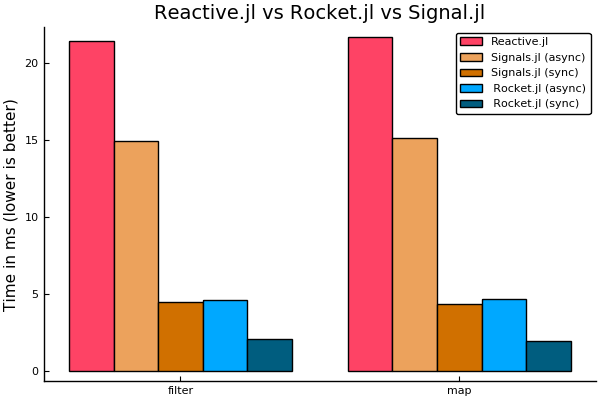

In [16]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
] ./ 1e6
sx = repeat(["Reactive.jl", "Signals.jl (async)", "Signals.jl (sync)", " Rocket.jl (async)", " Rocket.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 5)

groupedbar(nam, mn, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl vs Signal.jl", color=[c1 c2 c3 c4 c5])

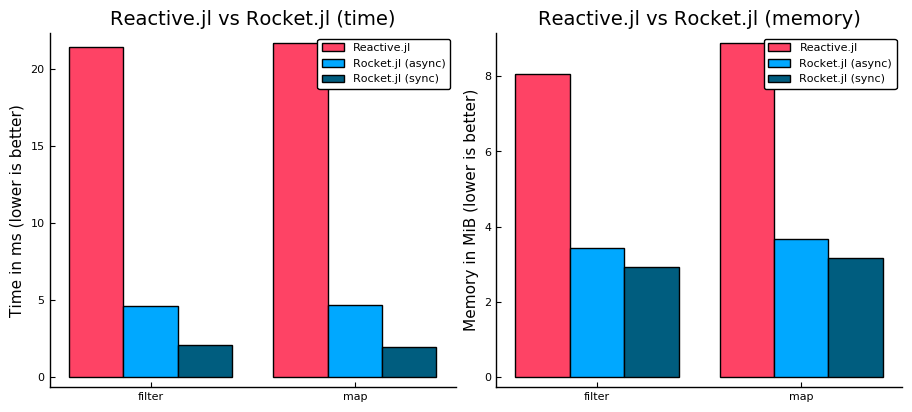

In [17]:
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 3)

mn = [
    bmap1, bfilter1,
    bmap4, bfilter4,
    bmap5, bfilter5,
]

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl (time)", color=[c1 c4 c5], legend=:topright)
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Reactive.jl vs Rocket.jl (memory)", color=[c1 c4 c5], legend=:topright)

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/reactive-rocket.svg")

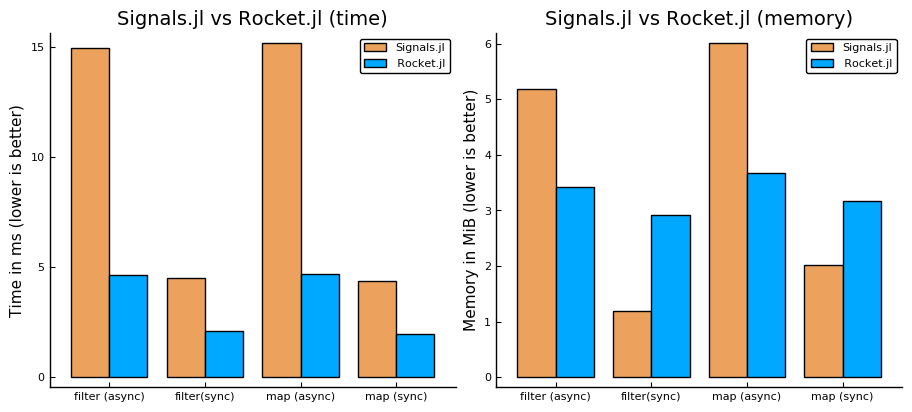

In [18]:
mn = [
    bmap4, bmap5, bfilter4, bfilter5,
    bmap2, bmap3, bfilter2, bfilter3
]

sx = repeat([" Rocket.jl", "Signals.jl"], inner = 4)
nam = repeat([ "map (async)", "map (sync)", "filter (async)", "filter(sync)" ], outer = 2)

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Signals.jl vs Rocket.jl (time)", color=[c2 c4])
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Signals.jl vs Rocket.jl (memory)", color=[c2 c4])

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/signals-rocket.svg")